In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch as PP
from shapely.geometry import Point, LineString, Polygon
#TODO: learn what these configs are doing
ox.settings.log_console = True
ox.settings.use_cache = True

Some of the initializations above had to be modified from example doc because of updates to osmnx

Following the 13-isplones-isochrones example in osmnx examples.
https://github.com/gboeing/osmnx-examples/blob/main/notebooks/00-osmnx-features-demo.ipynb

First attempting to use data I downloaded from osmnx website a week or so ago

I had to update the CRS so that I could display

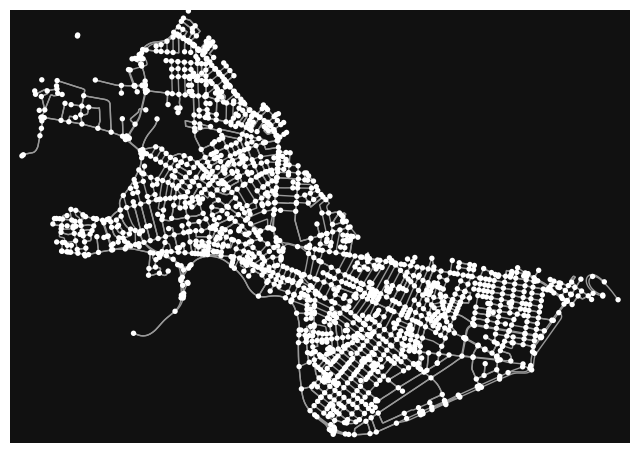

In [10]:
#test the upload of Cambridge GraphML file being stored locally and display
G = ox.load_graphml('Cambridge.graphml')
G.graph['crs'] = "EPSG:4326"
fig, ax = ox.plot.plot_graph(G)

Trying to do the same thing by downloading using built in API
Importing 'drive' network interesting to see it looks like there have been marginal updates to the imported data.

I plan to use the 'walk' network for my analysis so that is what is below

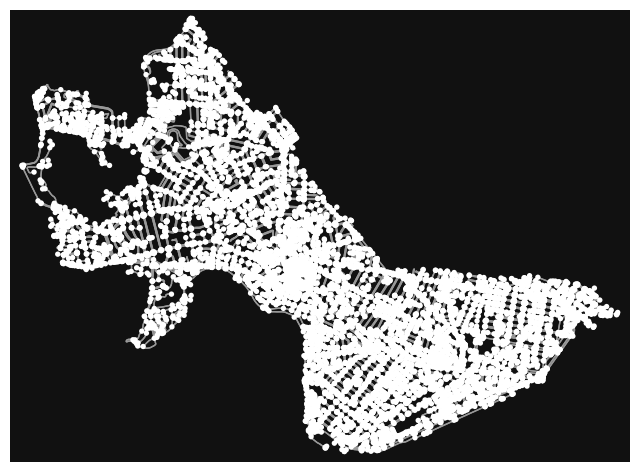

In [14]:
place = 'Cambridge, MA, USA'
network_type = 'walk'
G2 = ox.graph_from_place(place, network_type=network_type)
fig, ax = ox.plot.plot_graph(G2)


Now to ready the network for analysis
Convert to UTM for make math easier?
Need to understand why they need the centermost node
add an edge attribute for time in minutes required to traverse each edge
TODO: When I have more time, understand more about the processes being performed below

/var/folders/xd/7spswrf1365c8txnrr_tc37r0000gn/T/ipykernel_45189/1757074958.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  x, y = gdf_nodes['geometry'].unary_union.centroid.xy


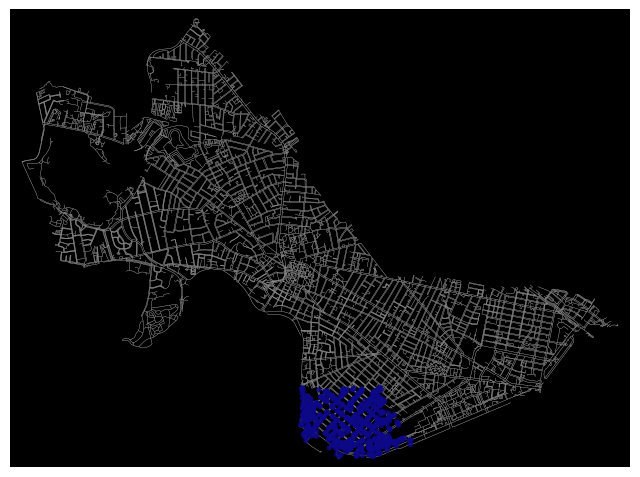

In [ ]:
gdf_nodes = ox.graph_to_gdfs(G2, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
#using coordinates for Central station in Cambridge
#nearest node functionality has changed
#center_node = ox.distance.nearest_nodes(G2, 42.365231753248764, -71.10364067006996)
center_node = ox.distance.nearest_nodes(G2, 0, 0)
G2 = ox.project_graph(G2)

trip_time = 15
travel_speed = 4.5

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G2.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

color = ox.plot.get_colors(n=1, cmap='plasma', start=0)[0]

# color the nodes according to isochrone then plot the street network
node_colors = {}
subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance='time')
for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G2.nodes()]
ns = [15 if node in node_colors else 0 for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')


Above block seems to be working ideally at finding the nodes within the buffer, would be nice to highlight edges as well. 

Major issue is that it is not centering around Central Station but instead a location nearby, I suspect it is an issue with Coordinate systems.

Next block is not yet functional: attempting to make a buffer based on the walkable nodes, but am having some trouble converting the example code to work for a single isochrone.

/var/folders/xd/7spswrf1365c8txnrr_tc37r0000gn/T/ipykernel_45189/3992262427.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union


IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

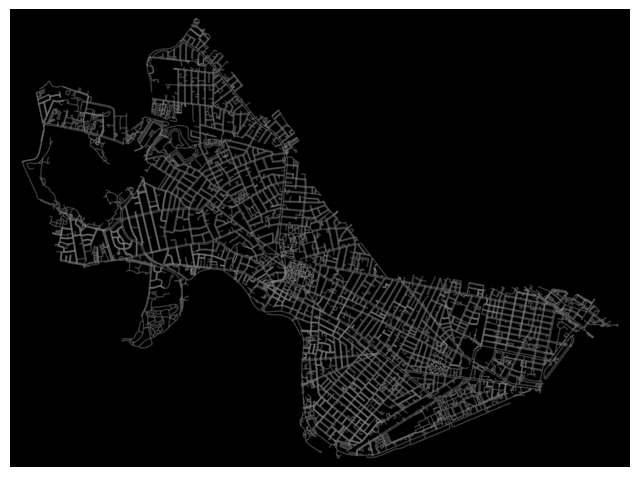

In [ ]:
#this section not yet functional, PP doesn't work well with one iso it seems

def make_iso_polys(G2, edge_buff=25, node_buff=50, infill=False):
    subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index('id')

    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lookup = G2.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
        edge_lines.append(edge_lookup)

    n = nodes_gdf.buffer(node_buff).geometry
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).unary_union
        
    # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
    if infill:
        new_iso = Polygon(new_iso.exterior)
    return new_iso

iso = make_iso_polys(G2, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G2, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
patch = PP(iso, fc=color, ec='none', alpha=0.6, zorder=-1)
ax.add_patch(patch)
plt.show()


TODO: play around with weighting to try to create an walkshed based on perceived range, accounting for elevation changes, # of turns and other factors that can deter pedestrians